<a href="https://colab.research.google.com/github/AndreyBarTF/turbines_autumn_2022-Homework/blob/%D0%94%D0%97.4/BarbashinATFe-0120%2C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   ФИО Барбашин Андрей Алексеевич
*   Группа ТФэ-01-20
*   Тлеграмм @QwertyAlexx

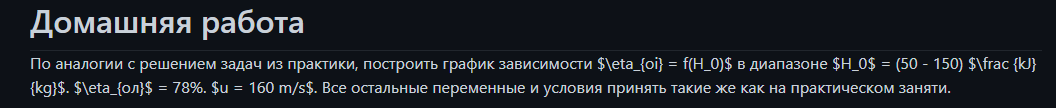

In [ ]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 9.4 MB/s 
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114280 sha256=905cbf00e6fad8a7579532ac260d51954e57686d049bc6c5a6ffc949770f23ff
  Stored in directory: /root/.cache/pip/wheels/31/41/85/a38aabccfd7dea1498653150e52ad2b2d7e3a8199263b8e09a
Successfully built iapws


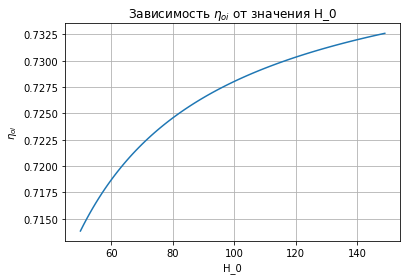

In [ ]:
import iapws
from iapws import IAPWS97 as gas
import math
import matplotlib.pyplot as plt
import numpy as np

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

#Исходные данные
p = 5 * MPa
t = to_kelvin(489)
H_0 = range(50,150)
u = 160
F1 = 0.025
d_r = 1.09
s_div_r = 0.2 
degree__of_reaction = 0.1
z_bandage = 2
delta_r_bandage = 1.17 / 1000
delta_a_bandage = 4 / 1000
z_rotor = 5
d_leak_rotor = 0.36
delta_leak_rotor = 0.4 / 1000
e = 0.8
sin_alpha_1 = 0.225
blade_width = 0.035
blade_length = 0.035
blade_efficiency = 0.78
segments = 4
m = 1
k = 0.065
mu_a = 0.5 # Для надбандажного уплотнения
mu_r = 0.8 # По графику mu = f(зазор / толщина усика) определим при delta_r_bandage / 0.004 ~ 0.3. Возьмем квадратное уплотнение
K_y = 1 # Примем, что диафрагменное уплотнение ступенчатое, т.е. Kу = 1
mu_r_rotor = 0.8 # По графику mu = f(зазор / толщина усика) определим при delta_leak_rotor / 0.004 ~ 0.1. Возьмем квадратное уплотнение
mu_nozzle = 0.97 # Примем коэффициент расхода сопловой решетки 0.97

point = gas(P=p * unit, T=t)
kinematic_viscosity = point.nu

def get_Re_number(u, d_r, kinematic_viscosity):
  Re_number = u * d_r * 0.5 / kinematic_viscosity
  return Re_number

def get_k_frictions(s_div_r, Re_number):
  k_f = 2.5 * 10 ** (-2) * s_div_r ** 0.1 * Re_number **(-0.2)
  return k_f

def get_friction_loss_pu(k_f, d_r, u_div_dummy_speed, F1):
  friction_loss_pu = k_f * d_r ** 2 * u_div_dummy_speed ** 3 / F1 
  return friction_loss_pu

def get_ventilation_loss_pu(m, k, sin_alpha_1, e, u_div_dummy_speed):
  first = k / sin_alpha_1
  second = (1 - e) / e
  third = u_div_dummy_speed ** 3   
  ventilation_loss_pu = first * second * third * m
  return ventilation_loss_pu

def get_segment_loss_pu(blade_width, blade_length, F1, u_div_dummy_speed, blade_efficiency, segments):
  B = blade_width
  l = blade_length
  F = F1
  first = 0.25 * B * l / F
  second = u_div_dummy_speed * blade_efficiency * segments
  segment_loss_pu = first * second
  return segment_loss_pu

def get_partial_losses_pu(segment_loss_pu, ventilation_loss_pu):
  partial_losses_pu = segment_loss_pu + ventilation_loss_pu
  return partial_losses_pu 

# Зададимся толщиной усика для уплотнения бандажа в 4 мм

def compute_equal_gap(z_bandage, delta_r_bandage, mu_r_rotor, delta_a_bandage, mu_a):
  z = z_bandage
  delta_r = delta_r_bandage
  delta_a = delta_a_bandage
  first = 1 / (mu_a * delta_a) ** 2
  second = z / (mu_r_rotor * delta_r) ** 2
  equal_gap = (first + second) ** (-0.5)
  return equal_gap

def get_bandage_leak_loss_pu(delta_r_bandage, equal_gap, F1, degree__of_reaction, blade_length, blade_efficiency):
  l = blade_length
  dor = degree__of_reaction
  delta_eq = equal_gap
  d_shroud = delta_r_bandage / 0.001 # По определению задачи
  d_avg = d_shroud - l
  first = math.pi * d_shroud * delta_eq / F1
  second = dor + 1.8 * (l / d_avg)
  bandage_leak_loss_pu = first * (second) ** 0.5 * blade_efficiency
  return bandage_leak_loss_pu

def get_disk_leak_loss_pu(K_y, d_leak_rotor, delta_leak_rotor, mu_r, mu_nozzle, F1, z_rotor, blade_efficiency):
  F_leak_rotor = math.pi * d_leak_rotor * delta_leak_rotor
  upper = mu_r * K_y * F_leak_rotor * blade_efficiency
  lower = mu_nozzle * F1 * z_rotor ** 0.5
  disk_leak_loss_pu = upper / lower
  return disk_leak_loss_pu

def get_leak_losses_pu(disk_leak_loss_pu, bandage_leak_loss_pu):
  leak_losses_pu = disk_leak_loss_pu + bandage_leak_loss_pu
  return leak_losses_pu

def compute_internal_efficiency(blade_efficiency, friction_loss_pu, partial_losses_pu, leak_losses_pu):
  internal_efficiency = blade_efficiency - friction_loss_pu - partial_losses_pu - leak_losses_pu
  return internal_efficiency

internal_efficiency = []
for H_0value in H_0:
  H_0value=H_0value*1000
  dummy_speed = (2 * H_0value) ** 0.5
  u_div_dummy_speed = u / dummy_speed

  Re_number = get_Re_number(u, d_r, kinematic_viscosity)
  k_f = get_k_frictions(s_div_r, Re_number)
  friction_loss_pu = get_friction_loss_pu(k_f, d_r, u_div_dummy_speed, F1)
  ventilation_loss_pu = get_ventilation_loss_pu(m, k, sin_alpha_1, e, u_div_dummy_speed)
  segment_loss_pu = get_segment_loss_pu(blade_width, blade_length, F1, u_div_dummy_speed, blade_efficiency, segments)
  partial_losses_pu = get_partial_losses_pu(segment_loss_pu, ventilation_loss_pu)
  equal_gap = compute_equal_gap(z_bandage, delta_r_bandage, mu_r_rotor, delta_a_bandage, mu_a)
  disk_leak_loss_pu = get_disk_leak_loss_pu(K_y, d_leak_rotor, delta_leak_rotor, mu_r, mu_nozzle, F1, z_rotor, blade_efficiency)
  bandage_leak_loss_pu = get_bandage_leak_loss_pu(delta_r_bandage, equal_gap, F1, degree__of_reaction, blade_length, blade_efficiency)
  leak_losses_pu = get_leak_losses_pu(disk_leak_loss_pu, bandage_leak_loss_pu)
  internal_efficiency.append(compute_internal_efficiency(blade_efficiency, friction_loss_pu, partial_losses_pu, leak_losses_pu))

X = H_0
Y = internal_efficiency
plt.plot(X,Y)  
plt.xlabel('H_0')
plt.ylabel('$\eta_{oi}$')
plt.title("Зависимость $\eta_{oi}$ от значения H_0")
plt.grid()